# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
**TODO**  
Both use the concept of parameter sharing. A convolutional neural network shares parameters across spatial locations, a recurrent neural network shares parameters across time (steps).

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
**TODO**  
While techinques such as the introduction of skip-connections or removing connections were shown to reduce the vanishing/exploding gradient effect, the currently most effective technique is to use gated  RNNs such as an LSTM cell or a GRU cell. Gated RNNs use an internal state and _learn_ gating values, which control how much of the information of a time step should be added to the internal state and how much of the old information should be forgotten. This circumvents that each step contributes with the same amount to the gradient of a parameter and therefore counteracts vanishing/exploding gradients.

## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        #we use hidden_size * 4 units as we can chunk the output later
        # 4: (gates for {input, forget, output} and a state update)
        self.linear = nn.Linear(input_size + hidden_size, hidden_size * 4, bias=True)
        self.linear_cell = nn.Linear(hidden_size, hidden_size * 4, bias=True)
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        hidden_state, internal_state = hx
        # START TODO #############
        # compute the gating and cell update vectors
        gates = self.linear(torch.cat((x, hidden_state), 1))
        # split the output into the four predictions (state_update, f, g, q)
        state_update, forget, external_input_gate, output_gate = \
             gates.chunk(chunks=4, dim=1)
        # Eq. 10.41: s^(t) = f^(t) * s^(t-1) + g^(t) * sig(b + Ux + Wh)
        new_internal_state = (forget.sigmoid() * internal_state +
                              external_input_gate.sigmoid() * state_update.sigmoid())
        # Eq 10.43
        # The new hidden state is also the output.
        new_hidden_state = new_internal_state.tanh() * output_gate.sigmoid()
        # END TODO #############
        return new_hidden_state, new_internal_state
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        return (torch.zeros(x.shape[0], self.hidden_size),
                torch.zeros(x.shape[0], self.hidden_size))
        # raise NotImplementedError
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)). 
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        hidden_states = []
        for sequence_el in x:
            hx = super().forward(sequence_el, hx)
            hidden_states.append(hx[0])
        return torch.stack(hidden_states, dim=0), hx
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

epoch: 0, loss:2.9838130474090576
test accuracy: 0.03
epoch: 10, loss:0.009571610949933529
test accuracy: 0.16
epoch: 20, loss:0.013183915056288242
test accuracy: 0.18
epoch: 30, loss:0.004180127289146185
test accuracy: 0.59
epoch: 40, loss:0.004714516922831535
test accuracy: 0.51
epoch: 50, loss:0.0015953545225784183
test accuracy: 0.79
epoch: 60, loss:0.004719867836683989
test accuracy: 0.4
epoch: 70, loss:0.0012367541203275323
test accuracy: 0.88
epoch: 80, loss:0.00017100939294323325
test accuracy: 0.93
epoch: 90, loss:0.00013996793131809682
test accuracy: 0.94
epoch: 100, loss:0.00013757345732301474
test accuracy: 0.95


## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

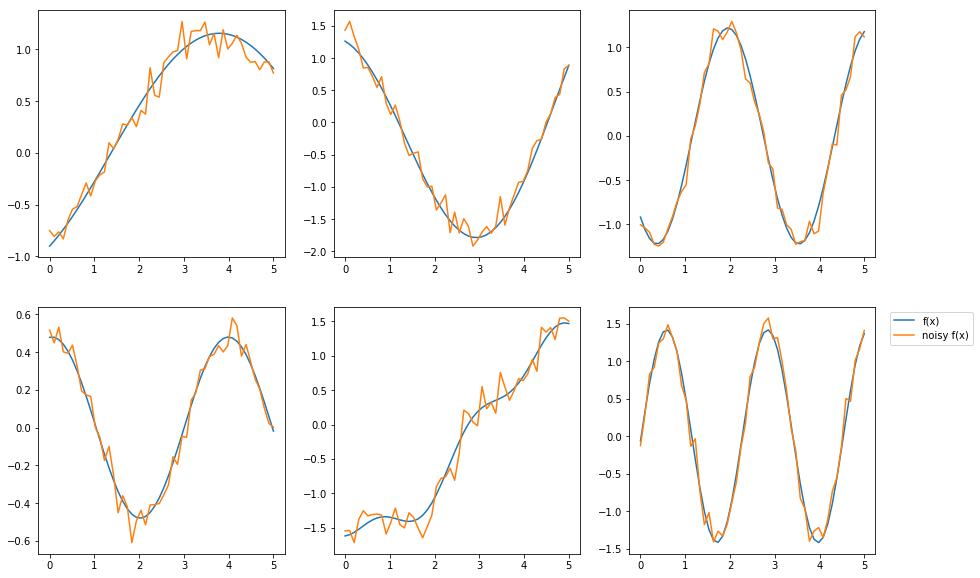

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
h, w = 2, 3
functions = sample_sine_functions(h*w)
x = np.linspace(0, 5, 50)

plt.figure(figsize=(15,10))
for i,f in enumerate(functions):
    plt.subplot(h, w, i + 1)
    plt.plot(x, f(x), label="f(x)")
    plt.plot(x, noisy(f(x), 0.05), label="noisy f(x)")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).

To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [20]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        self.lstm1 = LSTM(1, hidden_size)
        self.lstm2 = LSTM(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.shift zeros at the end,
        2) applies an LSTM
        3) cuts the first self.shift outputs
        4) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        padded = torch.functional.F.pad(x, (0, 0, 0, 0, 0, self.shift))
        hidden = self.lstm1(padded)[0][self.shift:]
        hidden = self.lstm2(hidden)[0]
        
        return self.linear(hidden)
        # END TODO #############

In [21]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [22]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    for epoch in range(num_epochs):
        # START TODO #############
        # training loop here
        for batch_idx in range(num_functions // batch_size):
            optimizer.zero_grad()
            start = batch_idx * batch_size
            end = start + batch_size
            batch_x = noisy_train_sequences[:, start:end]
            batch_label = train_sequences[:, start:end]
            output = model(batch_x)
            loss = loss_fn(batch_label, output)
            loss.backward()
            optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:1174.2899169921875
epoch: 0, validation loss:4620.16162109375


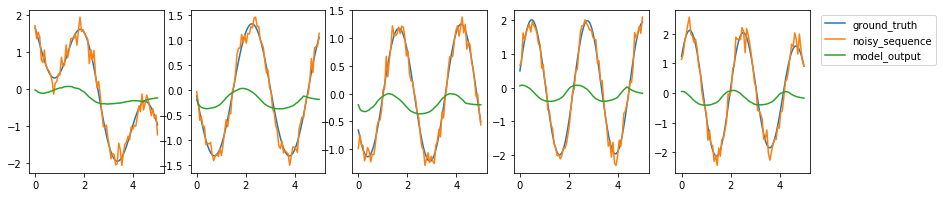

-581.4464% of noise removed.
epoch: 1, train loss:687.0906372070312
epoch: 1, validation loss:2172.130859375
epoch: 2, train loss:447.70550537109375
epoch: 2, validation loss:1262.083251953125
epoch: 3, train loss:265.20709228515625
epoch: 3, validation loss:782.7015380859375
epoch: 4, train loss:185.07559204101562
epoch: 4, validation loss:507.6947021484375
epoch: 5, train loss:79.65526580810547
epoch: 5, validation loss:288.87921142578125
epoch: 6, train loss:64.69960021972656
epoch: 6, validation loss:172.50311279296875
epoch: 7, train loss:51.73764419555664
epoch: 7, validation loss:167.7401885986328
epoch: 8, train loss:42.42318344116211
epoch: 8, validation loss:142.96214294433594
epoch: 9, train loss:36.415531158447266
epoch: 9, validation loss:149.6137237548828
epoch: 10, train loss:30.51621437072754
epoch: 10, validation loss:154.86929321289062


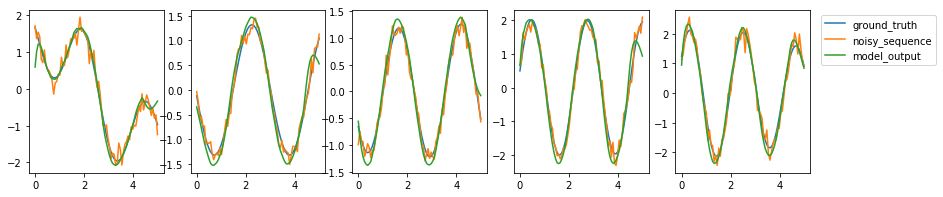

-7.1277% of noise removed.
epoch: 11, train loss:29.187652587890625
epoch: 11, validation loss:157.27288818359375
epoch: 12, train loss:28.52619743347168
epoch: 12, validation loss:155.66197204589844
epoch: 13, train loss:28.294050216674805
epoch: 13, validation loss:146.45973205566406
epoch: 14, train loss:28.080730438232422
epoch: 14, validation loss:132.28208923339844
epoch: 15, train loss:27.350955963134766
epoch: 15, validation loss:120.60932922363281
epoch: 16, train loss:26.105167388916016
epoch: 16, validation loss:112.93158721923828
epoch: 17, train loss:24.70592498779297
epoch: 17, validation loss:107.09542083740234
epoch: 18, train loss:23.544803619384766
epoch: 18, validation loss:102.78217315673828
epoch: 19, train loss:22.533309936523438
epoch: 19, validation loss:99.66856384277344
epoch: 20, train loss:21.628150939941406
epoch: 20, validation loss:97.29707336425781


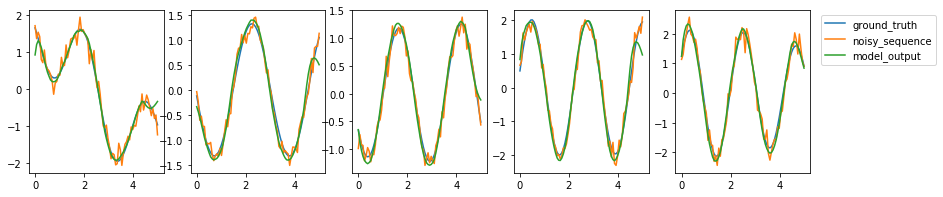

19.0021% of noise removed.
epoch: 21, train loss:20.804710388183594
epoch: 21, validation loss:95.32395935058594
epoch: 22, train loss:20.01197052001953
epoch: 22, validation loss:93.25699615478516
epoch: 23, train loss:19.38066864013672
epoch: 23, validation loss:91.2336196899414
epoch: 24, train loss:18.715652465820312
epoch: 24, validation loss:88.98577880859375
epoch: 25, train loss:18.299522399902344
epoch: 25, validation loss:87.50202178955078
epoch: 26, train loss:17.73839569091797
epoch: 26, validation loss:86.60477447509766
epoch: 27, train loss:17.2667293548584
epoch: 27, validation loss:86.54613494873047
epoch: 28, train loss:16.706459045410156
epoch: 28, validation loss:87.0558090209961
epoch: 29, train loss:16.206695556640625
epoch: 29, validation loss:88.02984619140625
epoch: 30, train loss:15.757831573486328
epoch: 30, validation loss:89.2594985961914


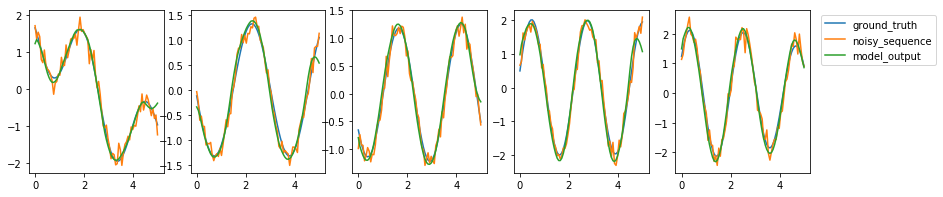

19.0681% of noise removed.
epoch: 31, train loss:15.516231536865234
epoch: 31, validation loss:90.06111907958984
epoch: 32, train loss:16.05185890197754
epoch: 32, validation loss:88.73682403564453
epoch: 33, train loss:18.57286262512207
epoch: 33, validation loss:81.67780303955078
epoch: 34, train loss:16.64470863342285
epoch: 34, validation loss:84.3900375366211
epoch: 35, train loss:14.875160217285156
epoch: 35, validation loss:66.52635955810547
epoch: 36, train loss:14.585779190063477
epoch: 36, validation loss:64.85322570800781
epoch: 37, train loss:13.573556900024414
epoch: 37, validation loss:65.31835174560547
epoch: 38, train loss:12.854257583618164
epoch: 38, validation loss:64.40802001953125
epoch: 39, train loss:12.350173950195312
epoch: 39, validation loss:62.426513671875
epoch: 40, train loss:11.954595565795898
epoch: 40, validation loss:60.41557693481445


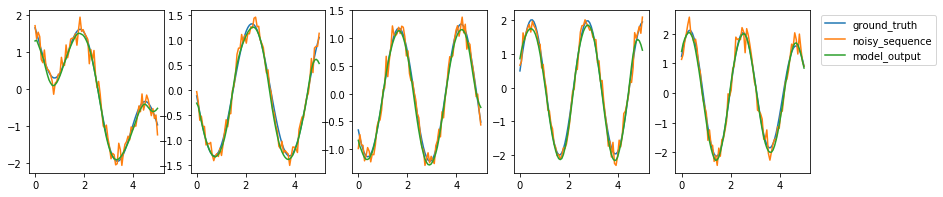

31.4297% of noise removed.
epoch: 41, train loss:11.629134178161621
epoch: 41, validation loss:58.54716491699219
epoch: 42, train loss:11.337509155273438
epoch: 42, validation loss:56.99803924560547
epoch: 43, train loss:11.067455291748047
epoch: 43, validation loss:55.62101745605469
epoch: 44, train loss:10.82370662689209
epoch: 44, validation loss:54.40291213989258
epoch: 45, train loss:10.612812042236328
epoch: 45, validation loss:53.37062454223633
epoch: 46, train loss:10.442636489868164
epoch: 46, validation loss:52.622432708740234
epoch: 47, train loss:10.32130241394043
epoch: 47, validation loss:52.37449645996094
epoch: 48, train loss:10.248547554016113
epoch: 48, validation loss:53.106781005859375
epoch: 49, train loss:10.170330047607422
epoch: 49, validation loss:55.83099365234375
epoch: 50, train loss:9.870733261108398
epoch: 50, validation loss:61.7714958190918


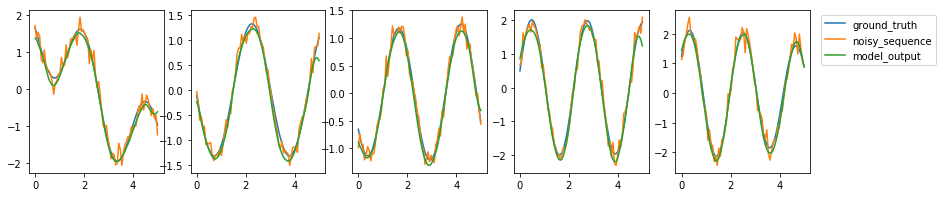

23.0356% of noise removed.
epoch: 51, train loss:9.234552383422852
epoch: 51, validation loss:67.03297424316406
epoch: 52, train loss:9.113913536071777
epoch: 52, validation loss:59.188350677490234
epoch: 53, train loss:8.942893981933594
epoch: 53, validation loss:49.88547897338867
epoch: 54, train loss:8.609249114990234
epoch: 54, validation loss:49.221229553222656
epoch: 55, train loss:8.450460433959961
epoch: 55, validation loss:48.30635452270508
epoch: 56, train loss:8.253170013427734
epoch: 56, validation loss:47.506317138671875
epoch: 57, train loss:8.099973678588867
epoch: 57, validation loss:47.36698913574219
epoch: 58, train loss:7.957974433898926
epoch: 58, validation loss:47.43971252441406
epoch: 59, train loss:7.8380045890808105
epoch: 59, validation loss:47.894683837890625
epoch: 60, train loss:7.744917869567871
epoch: 60, validation loss:48.726898193359375


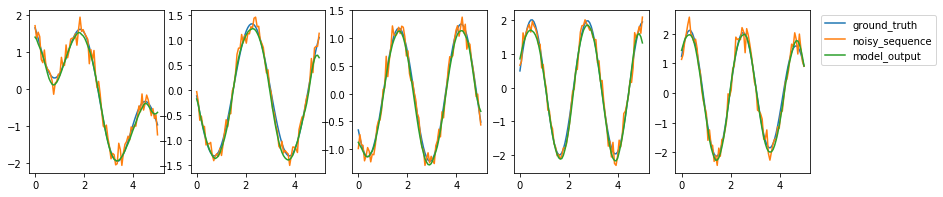

34.0459% of noise removed.
epoch: 61, train loss:7.7251200675964355
epoch: 61, validation loss:49.65415954589844
epoch: 62, train loss:7.948321342468262
epoch: 62, validation loss:49.16960906982422
epoch: 63, train loss:8.750861167907715
epoch: 63, validation loss:44.3459358215332
epoch: 64, train loss:9.515244483947754
epoch: 64, validation loss:37.20661544799805
epoch: 65, train loss:8.375933647155762
epoch: 65, validation loss:35.06684494018555
epoch: 66, train loss:7.55267333984375
epoch: 66, validation loss:35.153263092041016
epoch: 67, train loss:7.640366554260254
epoch: 67, validation loss:35.83702850341797
epoch: 68, train loss:7.574984550476074
epoch: 68, validation loss:36.33736801147461
epoch: 69, train loss:7.569887638092041
epoch: 69, validation loss:37.066463470458984
epoch: 70, train loss:7.629602432250977
epoch: 70, validation loss:37.65641784667969


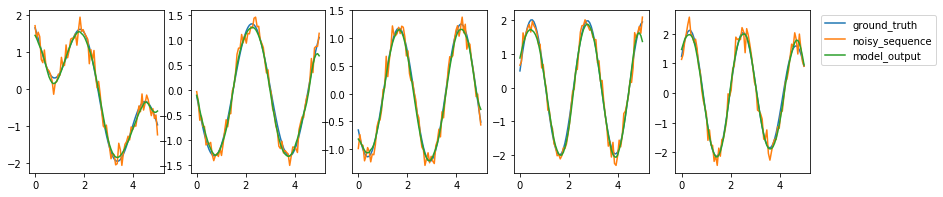

47.8481% of noise removed.
epoch: 71, train loss:7.6901021003723145
epoch: 71, validation loss:37.584503173828125
epoch: 72, train loss:7.931136608123779
epoch: 72, validation loss:36.5778694152832
epoch: 73, train loss:8.614307403564453
epoch: 73, validation loss:35.255855560302734
epoch: 74, train loss:9.549700736999512
epoch: 74, validation loss:36.26287841796875
epoch: 75, train loss:9.208420753479004
epoch: 75, validation loss:40.85727310180664
epoch: 76, train loss:7.558927059173584
epoch: 76, validation loss:39.173255920410156
epoch: 77, train loss:7.059019088745117
epoch: 77, validation loss:36.19459533691406
epoch: 78, train loss:7.071252822875977
epoch: 78, validation loss:36.33164978027344
epoch: 79, train loss:6.891109943389893
epoch: 79, validation loss:35.844093322753906
epoch: 80, train loss:6.834259986877441
epoch: 80, validation loss:35.61474609375


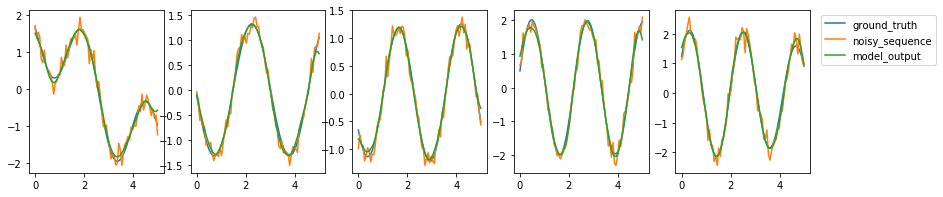

49.8543% of noise removed.
epoch: 81, train loss:6.782617568969727
epoch: 81, validation loss:35.444305419921875
epoch: 82, train loss:6.742580413818359
epoch: 82, validation loss:35.56412887573242
epoch: 83, train loss:6.629574775695801
epoch: 83, validation loss:35.87690353393555
epoch: 84, train loss:6.335315227508545
epoch: 84, validation loss:35.4310188293457
epoch: 85, train loss:6.042857646942139
epoch: 85, validation loss:33.50959777832031
epoch: 86, train loss:6.015216827392578
epoch: 86, validation loss:32.43928527832031
epoch: 87, train loss:5.989341735839844
epoch: 87, validation loss:32.268287658691406
epoch: 88, train loss:5.994319915771484
epoch: 88, validation loss:32.18377685546875
epoch: 89, train loss:5.9720916748046875
epoch: 89, validation loss:32.2140998840332
epoch: 90, train loss:5.94342565536499
epoch: 90, validation loss:32.12092208862305


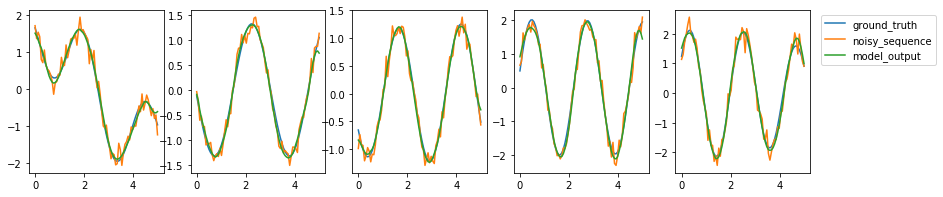

52.8824% of noise removed.
epoch: 91, train loss:5.932054042816162
epoch: 91, validation loss:32.01405715942383
epoch: 92, train loss:5.945882320404053
epoch: 92, validation loss:31.95299530029297
epoch: 93, train loss:5.999217510223389
epoch: 93, validation loss:32.017330169677734
epoch: 94, train loss:6.069545269012451
epoch: 94, validation loss:32.30928421020508
epoch: 95, train loss:6.018702983856201
epoch: 95, validation loss:32.313629150390625
epoch: 96, train loss:5.922898769378662
epoch: 96, validation loss:32.013916015625
epoch: 97, train loss:5.914880752563477
epoch: 97, validation loss:31.97300148010254
epoch: 98, train loss:5.909751892089844
epoch: 98, validation loss:31.958621978759766
epoch: 99, train loss:5.907543659210205
epoch: 99, validation loss:31.951580047607422
epoch: 100, train loss:5.906190395355225
epoch: 100, validation loss:31.947729110717773


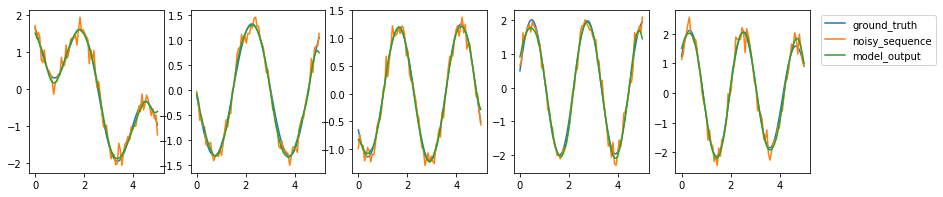

53.1756% of noise removed.


In [24]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~42% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

A few possibilities:

| configuration           | Noise removed in percent |
| --------------------    | --------------------------: |
| initial configuration   | 53.1756%               |
| train for 200 epochs    | 56.20%|
| hidden size 20          | 50.30%|
| hidden size 60          | 53.52 %|
| hidden size 40, shift 3 | 51.34 %|

In [26]:
# don't forget to create a new model each time!
# START TODO #############
print("Training for 200 epochs!")
model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=201)
train(model, optimizer, scheduler, num_epochs=201, batch_size=10, plot=False)

print("Hidden size is 20.")
model = NoiseRemovalModel(hidden_size=20, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=101)
train(model, optimizer, scheduler, num_epochs=101, batch_size=10, plot=False)


print("Hidden size is 60.")
model = NoiseRemovalModel(hidden_size=60, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=101)
train(model, optimizer, scheduler, num_epochs=101, batch_size=10, plot=False)

print("Shift is 3.")
model = NoiseRemovalModel(hidden_size=40, shift=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=101)
train(model, optimizer, scheduler, num_epochs=101, batch_size=10, plot=False)

Training for 200 epochs!
epoch: 0, train loss:946.3834228515625
epoch: 0, validation loss:3074.692626953125
-430.0862% of noise removed.
epoch: 1, train loss:735.458251953125
epoch: 1, validation loss:2566.647216796875
epoch: 2, train loss:465.7083740234375
epoch: 2, validation loss:1398.7418212890625
epoch: 3, train loss:350.57464599609375
epoch: 3, validation loss:929.7021484375
epoch: 4, train loss:281.7254943847656
epoch: 4, validation loss:871.0729370117188
epoch: 5, train loss:215.2574920654297
epoch: 5, validation loss:638.6025390625
epoch: 6, train loss:153.6146697998047
epoch: 6, validation loss:368.1272277832031
epoch: 7, train loss:104.39096069335938
epoch: 7, validation loss:247.28955078125
epoch: 8, train loss:76.60847473144531
epoch: 8, validation loss:184.24957275390625
epoch: 9, train loss:57.64442443847656
epoch: 9, validation loss:223.96588134765625
epoch: 10, train loss:50.56090545654297
epoch: 10, validation loss:243.9132537841797
-48.7677% of noise removed.
epoch: 

epoch: 93, train loss:4.619447231292725
epoch: 93, validation loss:41.0096321105957
epoch: 94, train loss:4.605349540710449
epoch: 94, validation loss:40.85690689086914
epoch: 95, train loss:4.593358516693115
epoch: 95, validation loss:40.771419525146484
epoch: 96, train loss:4.582449913024902
epoch: 96, validation loss:40.76537322998047
epoch: 97, train loss:4.572154998779297
epoch: 97, validation loss:40.85262680053711
epoch: 98, train loss:4.562463760375977
epoch: 98, validation loss:41.05270004272461
epoch: 99, train loss:4.5536017417907715
epoch: 99, validation loss:41.39540481567383
epoch: 100, train loss:4.545553684234619
epoch: 100, validation loss:41.927337646484375
38.5709% of noise removed.
epoch: 101, train loss:4.537464618682861
epoch: 101, validation loss:42.719383239746094
epoch: 102, train loss:4.5264506340026855
epoch: 102, validation loss:43.87586212158203
epoch: 103, train loss:4.506158828735352
epoch: 103, validation loss:45.53672409057617
epoch: 104, train loss:4.4

epoch: 184, train loss:2.9165573120117188
epoch: 184, validation loss:25.790210723876953
epoch: 185, train loss:2.9154226779937744
epoch: 185, validation loss:25.838396072387695
epoch: 186, train loss:2.9034078121185303
epoch: 186, validation loss:25.832523345947266
epoch: 187, train loss:2.8901543617248535
epoch: 187, validation loss:25.796096801757812
epoch: 188, train loss:2.882657289505005
epoch: 188, validation loss:25.769357681274414
epoch: 189, train loss:2.8790571689605713
epoch: 189, validation loss:25.755727767944336
epoch: 190, train loss:2.8764140605926514
epoch: 190, validation loss:25.744766235351562
56.1387% of noise removed.
epoch: 191, train loss:2.8744847774505615
epoch: 191, validation loss:25.735862731933594
epoch: 192, train loss:2.8731024265289307
epoch: 192, validation loss:25.72917366027832
epoch: 193, train loss:2.8720428943634033
epoch: 193, validation loss:25.723905563354492
epoch: 194, train loss:2.871234893798828
epoch: 194, validation loss:25.7198524475097

epoch: 75, train loss:11.622310638427734
epoch: 75, validation loss:50.48004150390625
epoch: 76, train loss:9.919822692871094
epoch: 76, validation loss:44.80818176269531
epoch: 77, train loss:9.770792007446289
epoch: 77, validation loss:42.62831497192383
epoch: 78, train loss:9.731691360473633
epoch: 78, validation loss:42.42208480834961
epoch: 79, train loss:9.6306734085083
epoch: 79, validation loss:41.82923126220703
epoch: 80, train loss:9.623051643371582
epoch: 80, validation loss:41.73799514770508
48.2096% of noise removed.
epoch: 81, train loss:9.661876678466797
epoch: 81, validation loss:41.9334831237793
epoch: 82, train loss:9.714165687561035
epoch: 82, validation loss:42.55510330200195
epoch: 83, train loss:9.672582626342773
epoch: 83, validation loss:43.47050857543945
epoch: 84, train loss:9.3373441696167
epoch: 84, validation loss:43.51617431640625
epoch: 85, train loss:8.85468578338623
epoch: 85, validation loss:41.3594856262207
epoch: 86, train loss:8.710871696472168
epoc

epoch: 67, train loss:6.217676162719727
epoch: 67, validation loss:38.505245208740234
epoch: 68, train loss:6.346681118011475
epoch: 68, validation loss:40.21630096435547
epoch: 69, train loss:6.506808757781982
epoch: 69, validation loss:42.95035171508789
epoch: 70, train loss:6.626519203186035
epoch: 70, validation loss:46.337425231933594
42.5029% of noise removed.
epoch: 71, train loss:6.62429666519165
epoch: 71, validation loss:48.07341384887695
epoch: 72, train loss:6.7171196937561035
epoch: 72, validation loss:45.180606842041016
epoch: 73, train loss:7.254600524902344
epoch: 73, validation loss:41.18473434448242
epoch: 74, train loss:7.110428333282471
epoch: 74, validation loss:43.54237747192383
epoch: 75, train loss:5.785568714141846
epoch: 75, validation loss:43.487220764160156
epoch: 76, train loss:5.442434310913086
epoch: 76, validation loss:38.8023681640625
epoch: 77, train loss:5.584366321563721
epoch: 77, validation loss:38.688995361328125
epoch: 78, train loss:5.5765695571

epoch: 59, train loss:7.735462665557861
epoch: 59, validation loss:41.62881851196289
epoch: 60, train loss:8.33469009399414
epoch: 60, validation loss:38.12456130981445
46.5220% of noise removed.
epoch: 61, train loss:8.495312690734863
epoch: 61, validation loss:35.430335998535156
epoch: 62, train loss:8.13640022277832
epoch: 62, validation loss:35.929466247558594
epoch: 63, train loss:8.320581436157227
epoch: 63, validation loss:36.96282196044922
epoch: 64, train loss:8.571196556091309
epoch: 64, validation loss:38.340450286865234
epoch: 65, train loss:8.908592224121094
epoch: 65, validation loss:40.90918731689453
epoch: 66, train loss:9.157150268554688
epoch: 66, validation loss:43.94743347167969
epoch: 67, train loss:9.029720306396484
epoch: 67, validation loss:45.42640686035156
epoch: 68, train loss:8.647117614746094
epoch: 68, validation loss:42.307594299316406
epoch: 69, train loss:8.816326141357422
epoch: 69, validation loss:37.153228759765625
epoch: 70, train loss:9.26166248321